# Importing PySpark and opening file

In [102]:
from pyspark.sql import SparkSession, functions as F
spark = SparkSession.builder.getOrCreate()

orders_df = spark.read \
                 .option('escape', '\"') \
                 .option('quote', '\"') \
                 .csv('./dataset/olist_orders_dataset.csv', header=True, multiLine=True, inferSchema=True)

reviews_df = spark.read \
                  .option('escape', '\"') \
                  .option('quote', '\"') \
                  .csv('./dataset/olist_order_reviews_dataset.csv', header=True, multiLine=True, inferSchema=True)

orders_df.printSchema()

reviews_df.printSchema()

root
 |-- order_id: string (nullable = true)
 |-- customer_id: string (nullable = true)
 |-- order_status: string (nullable = true)
 |-- order_purchase_timestamp: timestamp (nullable = true)
 |-- order_approved_at: timestamp (nullable = true)
 |-- order_delivered_carrier_date: timestamp (nullable = true)
 |-- order_delivered_customer_date: timestamp (nullable = true)
 |-- order_estimated_delivery_date: timestamp (nullable = true)

root
 |-- review_id: string (nullable = true)
 |-- order_id: string (nullable = true)
 |-- review_score: integer (nullable = true)
 |-- review_comment_title: string (nullable = true)
 |-- review_comment_message: string (nullable = true)
 |-- review_creation_date: timestamp (nullable = true)
 |-- review_answer_timestamp: timestamp (nullable = true)



# Selecting all orders ids and their respective purchase delivery time

+--------------------+-----------------------------+-----------------------------+
|            order_id|order_estimated_delivery_date|order_delivered_customer_date|
+--------------------+-----------------------------+-----------------------------+
|e481f51cbdc54678b...|          2017-10-18 00:00:00|          2017-10-10 21:25:13|
|53cdb2fc8bc7dce0b...|          2018-08-13 00:00:00|          2018-08-07 15:27:45|
|47770eb9100c2d0c4...|          2018-09-04 00:00:00|          2018-08-17 18:06:29|
|949d5b44dbf5de918...|          2017-12-15 00:00:00|          2017-12-02 00:28:42|
|ad21c59c0840e6cb8...|          2018-02-26 00:00:00|          2018-02-16 18:17:02|
|a4591c265e18cb1dc...|          2017-08-01 00:00:00|          2017-07-26 10:57:55|
|136cce7faa42fdb2c...|          2017-05-09 00:00:00|                         null|
|6514b8ad8028c9f2c...|          2017-06-07 00:00:00|          2017-05-26 12:55:51|
|76c6e866289321a7c...|          2017-03-06 00:00:00|          2017-02-02 14:08:10|
|e69

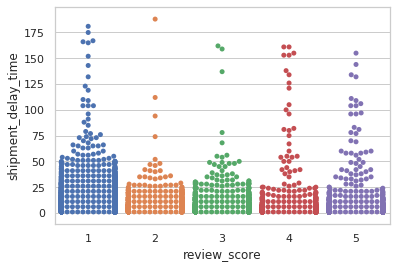

In [103]:
orders_df.select('order_id', 'order_estimated_delivery_date', 'order_delivered_customer_date').show()

orders_df = orders_df.withColumn('shipment_delay_time', F.datediff('order_estimated_delivery_date', 'order_delivered_customer_date')) \
                     .filter(F.col('order_status') == 'delivered').filter(F.col('shipment_delay_time') < 0).select('order_id', 'shipment_delay_time')
orders_df.show()

orders_df = orders_df.join(reviews_df, orders_df.order_id == reviews_df.order_id).select('shipment_delay_time', 'review_score') \
                     .orderBy('shipment_delay_time').withColumn('shipment_delay_time', -orders_df['shipment_delay_time'])

#orders_df.toPandas().plot(x ='review_score', y='shipment_delay_time', kind = 'scatter')

import seaborn as sns
import pandas as pd
sns.set(style="whitegrid")
ax = sns.swarmplot(x='review_score', y='shipment_delay_time', data=orders_df.toPandas())

# Conclusion:

### It's not possible to conclude that the shipment delay time is related to a low a review grade